In [12]:
import gym
import numpy as np
from tet.Execute import Execute
import os
import matplotlib.pyplot as plt

In [13]:
MAX_BOSONS_DONOR = 12
MAX_BOSONS_ACCEPTOR = 12
CHI_MIN = -5
CHI_MAX = 5
COUPLING = 0.1
OMEGA_D = 3
OMEGA_A = -3
MAX_T = 200

In [26]:
class DiscreteBreather(gym.Env):
    def __init__(self):
        super(DiscreteBreather, self).__init__()
        
        # s = [xD, xA]
        self.observation_space = gym.spaces.Box(low=np.array([0, CHI_MIN, CHI_MAX]), 
                                                high=np.array([MAX_BOSONS_ACCEPTOR, CHI_MIN, CHI_MAX]),
                                                shape=(3,))
        
        self.temp_ar = np.linspace(CHI_MIN, CHI_MAX, 100)
        self.chiA = np.random.choice(self.temp_ar)
        self.chiD = np.random.choice(self.temp_ar)
        
        # a = [delta xD, delta xA]
        self.action_space = gym.spaces.Discrete(3)
        
        self.reward = MAX_BOSONS_DONOR - MAX_BOSONS_DONOR
        
    def reset(self):
        self.chiA = np.random.choice(self.temp_ar)
        self.chiD = np.random.choice(self.temp_ar)
        return np.array([MAX_BOSONS_DONOR], dtype=np.float32)
    
    def step(self, action):
        if action == 0:
            self.chiA += np.diff(self.temp_ar)[0]
        elif action == 1:
            self.chiD += np.diff(self.temp_ar)[0]
        elif action == 2:
            self.chiA -= np.diff(self.temp_ar)[0]
        elif action == 3:
            self.chiD -= np.diff(self.temp_ar)[0]
        elif action > 3:
            pass
        
        avgN = Execute(chiA=self.chiA,
                       chiD=self.chiD,
                       max_N=MAX_BOSONS_DONOR,
                       max_t=MAX_T,
                       coupling_lambda=COUPLING,
                       omegaA=OMEGA_A,
                       omegaD=OMEGA_D,
                       data_dir=os.getcwd(),
                       return_data=True)()
        
        minN = np.min(avgN)
        
        self.observation = np.array([minN, self.chiA, self.chiD], dtype=np.float32)
        
        self.reward = MAX_BOSONS_DONOR - minN
        done = bool(self.reward >= 11)
        
        info = {}
        
        return self.observation, self.reward, done, info

In [27]:
env = DiscreteBreather()

/Users/jasonandronis/miniconda3/envs/ml/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [31]:
def test_policy(obs):
    if obs[0]>5:
        return np.random.randint(1)
    else:
        return np.random.randint(3)

eps = []
rwds_mean = []
# env is created, now we can use it: 
for episode in range(10): 
    observation = env.reset()
    rwds = []
    for step in range(10):
#         action = env.action_space.sample()  # or given a custom model, action = policy(observation)
        action = test_policy(observation)
        observation, reward, done, info = env.step(action)
        rwds.append(reward)
    print(f'Episode done: {reward} - {observation}')
    rwds_mean.append(np.mean(rwds))
    eps.append(episode)

Episode done: 0.12745225541739735 - [11.872548  5.        5.      ]
Episode done: 0.16036188804868523 - [11.839638    3.989899    0.75757575]
Episode done: 0.11975852407376841 - [11.880241   3.8888888 -3.8888888]
Episode done: 0.11975852407377374 - [11.880241   2.4747474 -1.5656565]
Episode done: 0.171871272679736 - [11.828129   -3.6868687   0.15151516]
Episode done: 0.13460697140239652 - [11.865393  -1.8686869  2.1717172]
Episode done: 0.1197585240737542 - [11.880241    0.75757575 -3.8888888 ]
Episode done: 0.14412385321701215 - [11.855876  -0.959596   1.1616162]
Episode done: 0.11975852407377907 - [11.880241  -2.979798  -3.7878788]
Episode done: 0.1520254886696506 - [11.847975   -0.959596    0.75757575]


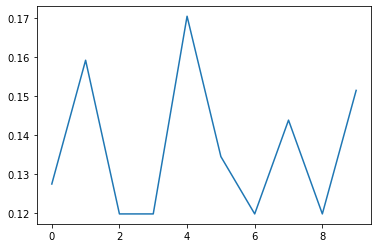

In [32]:
plt.plot(eps, rwds_mean)
plt.show()